## 🔍 Attention Mechanism (Scaled Dot-Product)

The core formula of Attention is:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^T}{\sqrt{d_k}} \right) V
$$

Where:

- \( Q \): Query matrix
- \( K \): Key matrix
- \( V \): Value matrix
- \( d_k \): Dimension of the key vectors (used for scaling)

### 🧠 Intuition

The attention mechanism lets the model **focus on the most relevant input tokens** when generating each output, based on the similarity between query and key vectors.

It computes a weighted sum of all values (V), where the weights are determined by how well each key (K) matches the current query (Q).



### Input Tokens and Random Embeddings

### 📦 Input Embedding Matrix $X$ with Tokens

\[
\begin{array}{cccc|c}
\text{Dim 1} & \text{Dim 2} & \text{Dim 3} & \text{Dim 4} & \text{Token} \\
\hline
\phantom{-}0.3374 & -0.1778 & -0.3035 & -0.5880 & \text{"Once"} \\
\phantom{-}1.5810 & \phantom{-}1.3010 & \phantom{-}1.2753 & -0.2010 & \text{"upon"} \\
-0.1606 & -0.4015 & \phantom{-}0.6957 & -1.8061 & \text{"a"} \\
-1.1589 & \phantom{-}0.3255 & -0.6315 & -2.8400 & \text{"time"} \\
-0.7849 & -1.4096 & -0.4076 & \phantom{-}0.7953 & \text{"there"}
\end{array}
\]


In [1]:
import torch
import torch.nn as nn

torch.manual_seed(123)

tokens = ["Once", "upon", "a", "time", "there"]
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
embedding_dim = 4

embedding_layer = nn.Embedding(num_embeddings=len(tokens), embedding_dim=embedding_dim)

input_indices = torch.tensor([token_to_idx[token] for token in tokens])  # [0,1,2,3,4]
X = embedding_layer(input_indices)
print("shape of input X:", X.shape)
print(X)

shape of input X: torch.Size([5, 4])
tensor([[ 0.3374, -0.1778, -0.3035, -0.5880],
        [ 1.5810,  1.3010,  1.2753, -0.2010],
        [-0.1606, -0.4015,  0.6957, -1.8061],
        [-1.1589,  0.3255, -0.6315, -2.8400],
        [-0.7849, -1.4096, -0.4076,  0.7953]], grad_fn=<EmbeddingBackward0>)


### Create Query, Key, and Value Matrices

In [6]:
torch.manual_seed(123)

W_Q = torch.nn.Parameter(torch.rand(embedding_dim, embedding_dim), requires_grad=False)
W_K = torch.nn.Parameter(torch.rand(embedding_dim, embedding_dim), requires_grad=False)
W_V = torch.nn.Parameter(torch.rand(embedding_dim, embedding_dim), requires_grad=False)

print("shape of W_Q:", W_Q.shape)
print("W_Q:", W_Q)

Q = X @ W_Q
K = X @ W_K
V = X @ W_V

print("shape of Q:", Q.shape)
print("Q:", Q)


shape of W_Q: torch.Size([4, 4])
W_Q: Parameter containing:
tensor([[0.2961, 0.5166, 0.2517, 0.6886],
        [0.0740, 0.8665, 0.1366, 0.1025],
        [0.1841, 0.7264, 0.3153, 0.6871],
        [0.0756, 0.1966, 0.3164, 0.4017]])
shape of Q: torch.Size([5, 4])
Q: tensor([[-0.0136, -0.3159, -0.2211, -0.2307],
        [ 0.7839,  2.8310,  0.9140,  2.0175],
        [-0.0858, -0.2806, -0.4474, -0.3992],
        [-0.6501, -1.3338, -1.3449, -2.3394],
        [-0.3515, -1.7666, -0.2669, -0.6454]], grad_fn=<MmBackward0>)



### Compute similarity (dot product between Q and K):

$$
\text{scores} = Q K^T
$$


In [10]:
scores = Q @ K.T
print("shape of scores:", scores.shape)
print("scores:", scores)

shape of scores: torch.Size([5, 5])
scores: tensor([[  0.3101,  -2.0474,   0.7024,   1.8280,   1.0647],
        [ -2.5714,  17.4476,  -5.5017, -14.6920,  -9.3044],
        [  0.6084,  -2.9632,   1.4480,   3.1775,   1.4642],
        [  2.8736, -14.6337,   6.4597,  14.7155,   7.4156],
        [  0.9222,  -8.1955,   1.8808,   5.9959,   4.5150]],
       grad_fn=<MmBackward0>)



2. **Scale the scores:**

$$
\text{scaled\_scores} = \frac{Q K^T}{\sqrt{d_k}}
$$


In [13]:
import math

attention_scores = scores / math.sqrt(embedding_dim)
print(attention_scores)

tensor([[ 0.1551, -1.0237,  0.3512,  0.9140,  0.5323],
        [-1.2857,  8.7238, -2.7508, -7.3460, -4.6522],
        [ 0.3042, -1.4816,  0.7240,  1.5888,  0.7321],
        [ 1.4368, -7.3169,  3.2298,  7.3577,  3.7078],
        [ 0.4611, -4.0977,  0.9404,  2.9979,  2.2575]], grad_fn=<DivBackward0>)


### Apply softmax to obtain attention weights

$$
\text{attention\_weights} = \text{softmax} \left( \frac{Q K^T}{\sqrt{d_k}} \right)
$$

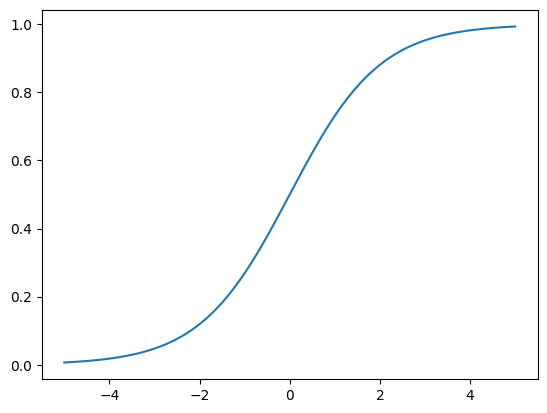

In [18]:
import torch
import matplotlib.pyplot as plt

x = torch.linspace(-5, 5, 200)
scores = torch.stack([x, torch.zeros_like(x)], dim=1)
softmax_vals = torch.softmax(scores, dim=1)

plt.plot(x.numpy(), softmax_vals[:,0].numpy())
plt.show()

In [22]:
import numpy as np

def softmax(x):
    e_x = np.exp(x) # e_x = np.exp(x - np.max(x)) is better for stability
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

scores_np = attention_scores.detach().numpy()
attention_weights = softmax(scores_np)
print(attention_weights)

[[1.6343656e-01 5.0282925e-02 1.9884653e-01 3.4909919e-01 2.3833480e-01]
 [4.4966473e-05 9.9994296e-01 1.0389488e-05 1.0493805e-07 1.5518635e-06]
 [1.2761034e-01 2.1395484e-02 1.9417544e-01 4.6106294e-01 1.9575578e-01]
 [2.5676459e-03 4.0538399e-07 1.5425654e-02 9.5712799e-01 2.4878288e-02]
 [4.6963401e-02 4.9190823e-04 7.5843528e-02 5.9360790e-01 2.8309324e-01]]


In [25]:
attention_weights = torch.softmax(attention_scores, dim=-1)
print("shape of attention_weights:", attention_weights.shape)
print(attention_weights)

shape of attention_weights: torch.Size([5, 5])
tensor([[1.6344e-01, 5.0283e-02, 1.9885e-01, 3.4910e-01, 2.3833e-01],
        [4.4966e-05, 9.9994e-01, 1.0389e-05, 1.0494e-07, 1.5519e-06],
        [1.2761e-01, 2.1395e-02, 1.9418e-01, 4.6106e-01, 1.9576e-01],
        [2.5676e-03, 4.0538e-07, 1.5426e-02, 9.5713e-01, 2.4878e-02],
        [4.6963e-02, 4.9191e-04, 7.5844e-02, 5.9361e-01, 2.8309e-01]],
       grad_fn=<SoftmaxBackward0>)


### Use the weights to compute a weighted sum of values

$$
\text{output} = \text{attention\_weights} \cdot V
$$


In [26]:
# Final output of self-attention
output = attention_weights @ V
print("shape of output:", output.shape)
print(output)

shape of output: torch.Size([5, 4])
tensor([[-1.0221, -1.1318, -1.0966, -1.2475],
        [ 1.6613,  1.7716,  2.1347,  2.5049],
        [-1.3064, -1.3985, -1.3982, -1.5418],
        [-2.2928, -2.2490, -2.4211, -2.5138],
        [-1.6010, -1.6693, -1.7563, -1.9028]], grad_fn=<MmBackward0>)


### build simple Self-Attention

In [28]:
import torch
import torch.nn as nn

class SelfAttentionV1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_Q = nn.Parameter(torch.rand(d_in, d_out))
        self.W_K = nn.Parameter(torch.rand(d_in, d_out))
        self.W_V = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        Q = x @ self.W_Q  # (seq_len, d_out)
        K = x @ self.W_K
        V = x @ self.W_V

        scores = Q @ K.T / K.shape[-1]**0.5  # (seq_len, seq_len)
        weights = torch.softmax(scores, dim=-1)

        context = weights @ V  # (seq_len, d_out)
        return context


In [29]:
torch.manual_seed(123)
sa = SelfAttentionV1(4, 4)
output = sa(X)
print(output)

tensor([[-1.0221, -1.1318, -1.0966, -1.2475],
        [ 1.6613,  1.7716,  2.1347,  2.5049],
        [-1.3064, -1.3985, -1.3982, -1.5418],
        [-2.2928, -2.2490, -2.4211, -2.5138],
        [-1.6010, -1.6693, -1.7563, -1.9028]], grad_fn=<MmBackward0>)


In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttentionV2(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        # (d_in, d_out)
        self.W_Q = nn.Linear(d_in, d_out, bias=False)
        self.W_K = nn.Linear(d_in, d_out, bias=False)
        self.W_V = nn.Linear(d_in, d_out, bias=False)

    def forward(self, x):
        # (seq_len, d_in) x (d_in, d_out) -> (seq_len, d_out)
        Q = self.W_Q(x)  # equal to: x @ W_Q.T
        K = self.W_K(x)
        V = self.W_V(x)

        # (seq_len, d_out) x (d_out, seq_len) -> (seq_len, seq_len)
        scores = Q @ K.transpose(-2, -1) / K.shape[-1]**0.5
        # (seq_len, seq_len)
        weights = F.softmax(scores, dim=-1)
        # (seq_len, seq_len) x (seq_len, d_out) -> # (seq_len, d_out)
        context = weights @ V
        return context


In [52]:
torch.manual_seed(123)
sa = SelfAttentionV2(4, 4)
output = sa(X)
print(output)

tensor([[ 0.1318, -0.1000, -0.4239, -0.0858],
        [-0.0532,  0.2164, -0.8386, -0.1107],
        [ 0.2318, -0.2270, -0.4083, -0.0919],
        [ 0.4762, -0.5514, -0.2901, -0.0859],
        [ 0.0700, -0.0399, -0.3281, -0.0728]], grad_fn=<MmBackward0>)


### Casual Attention: Mask future words

In [63]:
import torch

context_size = attention_scores.shape[0]
# Lower triangular mask
mask = torch.tril(torch.ones(context_size, context_size))
print(mask)
mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, 0.0)
print(mask)

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])
tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


In [64]:
print("original scores: \n", attention_scores)
# Apply mask to scores
masked_scores = attention_scores + mask
print("masked scores:\n", masked_scores)

original scores: 
 tensor([[ 0.1551, -1.0237,  0.3512,  0.9140,  0.5323],
        [-1.2857,  8.7238, -2.7508, -7.3460, -4.6522],
        [ 0.3042, -1.4816,  0.7240,  1.5888,  0.7321],
        [ 1.4368, -7.3169,  3.2298,  7.3577,  3.7078],
        [ 0.4611, -4.0977,  0.9404,  2.9979,  2.2575]], grad_fn=<DivBackward0>)
masked scores:
 tensor([[ 0.1551,    -inf,    -inf,    -inf,    -inf],
        [-1.2857,  8.7238,    -inf,    -inf,    -inf],
        [ 0.3042, -1.4816,  0.7240,    -inf,    -inf],
        [ 1.4368, -7.3169,  3.2298,  7.3577,    -inf],
        [ 0.4611, -4.0977,  0.9404,  2.9979,  2.2575]], grad_fn=<AddBackward0>)


### Dropout
- scaled: 1 / (1 - `dropout_rate`)


In [77]:
import torch

torch.manual_seed(123)

# Create a dropout layer with 20% dropout rate
dropout = torch.nn.Dropout(0.2)
dropout.train()  # Explicitly set to training mode to enable dropout

example = torch.ones(5, 5)
print("Input tensor:\n",example)

# Apply dropout to the input tensor
output = dropout(example)
print("tensor after Dropout:\n",output)
print(f"Number of zeros in output: {(output == 0).sum().item()}")
print(f"Output mean value (should be ~1.0 due to scaling): {output.mean().item():.4f}")

Input tensor:
 tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])
tensor after Dropout:
 tensor([[1.2500, 1.2500, 1.2500, 1.2500, 1.2500],
        [1.2500, 1.2500, 1.2500, 0.0000, 1.2500],
        [0.0000, 1.2500, 1.2500, 1.2500, 1.2500],
        [1.2500, 1.2500, 1.2500, 1.2500, 1.2500],
        [1.2500, 1.2500, 1.2500, 1.2500, 1.2500]])
Number of zeros in output: 2
Output mean value (should be ~1.0 due to scaling): 1.1500


In [81]:
weights = F.softmax(masked_scores, dim=-1)
print("weights after mask: \n", weights)
torch.manual_seed(123)
output = dropout(weights)
print("weights after Dropout: \n", output)

weights after mask: 
 tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [4.4967e-05, 9.9996e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.7185e-01, 6.2345e-02, 5.6581e-01, 0.0000e+00, 0.0000e+00],
        [2.6332e-03, 4.1573e-07, 1.5819e-02, 9.8155e-01, 0.0000e+00],
        [4.6963e-02, 4.9191e-04, 7.5844e-02, 5.9361e-01, 2.8309e-01]],
       grad_fn=<SoftmaxBackward0>)
weights after Dropout: 
 tensor([[1.2500e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [5.6209e-05, 1.2499e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 7.7931e-02, 7.0726e-01, 0.0000e+00, 0.0000e+00],
        [3.2914e-03, 5.1966e-07, 1.9774e-02, 1.2269e+00, 0.0000e+00],
        [5.8704e-02, 6.1489e-04, 9.4804e-02, 7.4201e-01, 3.5387e-01]],
       grad_fn=<MulBackward0>)


### Casual Self-Attention code

In [109]:
import torch
import torch.nn as nn

class CausalAttention(nn.Module):
    """
    Implements single-head causal self-attention with optional dropout.
    """
    def __init__(self, d_in, d_out, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()
        # (d_in, d_out)
        self.W_Q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_K = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_V = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)

        # Create a fixed causal mask (upper triangular) [1 means "mask"]
        mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
        self.register_buffer("mask", mask.bool())

    def forward(self, x):
        # x: shape (batch_size, seq_len, d_in)
        batch_size, seq_len, _ = x.size()
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        # Compute attention scores
        scores = Q @ K.transpose(-2, -1) / (d_out ** 0.5)  # (batch_size, seq_len, seq_len)

        # Apply causal mask
        scores = scores.masked_fill(self.mask[:seq_len, :seq_len], -torch.inf)

        # Compute softmax weights and apply dropout
        weights = torch.softmax(scores, dim=-1)
        weights = self.dropout(weights)

        # Compute output
        output = weights @ V  # (batch_size, seq_len, d_out)
        return output


In [112]:
torch.manual_seed(123)

batch = torch.randn(2, 5, 4)  # (batch_size=2, seq_len=5, d_in=4)
d_in = 4
d_out = 4
context_length = batch.size(1)

ca = CausalAttention(d_in, d_out, context_length, dropout=0.0)
context_vecs = ca(batch)

print("context_vecs.shape:", context_vecs.shape)
print("context_vecs:\n", context_vecs)

context_vecs.shape: torch.Size([2, 5, 4])
context_vecs:
 tensor([[[-0.0487, -0.0112,  0.0449,  0.3506],
         [ 0.0439,  0.1278,  0.1848,  0.1733],
         [-0.2467, -0.1078,  0.2722,  0.5128],
         [-0.1638,  0.0053,  0.3753,  0.3111],
         [ 0.0264,  0.1455,  0.3622,  0.0182]],

        [[ 0.0960,  0.4257,  1.7419,  0.2045],
         [-0.0967,  0.2774,  1.1946,  0.5023],
         [ 0.1017,  0.2037,  0.4849,  0.1862],
         [-0.0775,  0.1062,  0.3737,  0.3387],
         [-0.1181, -0.0113,  0.1070,  0.2743]]], grad_fn=<UnsafeViewBackward0>)


### Multi-head Attention

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch03_compressed/24.webp" width="800px">


In [139]:
class MultiHeadAttentionWrapper(nn.Module):
    """
    Implements multi-head self-attention by stacking multiple heads.
    """

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.head_dim = d_out // num_heads
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, self.head_dim, context_length, dropout, qkv_bias) for _ in range(num_heads)])

    def forward(self, x):
        output = torch.cat([head(x) for head in self.heads], dim=-1)
        return output

In [141]:
torch.manual_seed(123)

batch = torch.randn(2, 5, 6)  # (batch_size=2, seq_len=5, d_in=6)
d_in = 6
d_out = 6
context_length = batch.size(1)

mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, dropout=0.0,num_heads=2)
context_vecs = mha(batch)

print("context_vecs.shape:", context_vecs.shape)
print("context_vecs:\n", context_vecs)


context_vecs.shape: torch.Size([2, 5, 6])
context_vecs:
 tensor([[[-0.0067, -0.0370,  0.2712, -0.5243, -0.0242, -0.0438],
         [-0.1782,  0.0173, -0.0166, -0.2391, -0.0284,  0.2177],
         [-0.1541,  0.2878, -0.2018,  0.2535,  0.0242,  0.3002],
         [-0.2817,  0.5219, -0.0699,  0.5508, -0.2767,  0.3709],
         [-0.0355, -0.1721,  0.0981,  0.2389, -0.1460,  0.1938]],

        [[ 0.7943, -1.9382,  0.2171, -1.6710,  0.7970, -1.3094],
         [ 0.2519, -1.1446,  0.2991, -1.5203,  0.3135, -0.9541],
         [ 0.1920, -0.8646,  0.3794, -0.9135,  0.0203, -0.5454],
         [ 0.2565, -0.8320,  0.1292, -0.9259,  0.2156, -0.4762],
         [ 0.1519, -0.5043,  0.1079, -0.3281,  0.1523, -0.1446]]],
       grad_fn=<CatBackward0>)


- This version of `MultiHeadAttention` is closer to real-world implementations, such as in GPT models.
- Instead of multiple separate `CausalAttention` modules, it splits `Q`, `K`, `V` into multiple heads via reshaping.
- It uses a causal mask to ensure autoregressive behavior (no peeking into the future).


In [144]:
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    """
    Implements multi-head attention by splitting the attention matrix into multiple heads.
    """

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_Q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_K = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_V = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_O = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
        self.register_buffer("mask", mask.bool())

    def forward(self, x):
        # shape (batch_size, seq_len, d_in)
        batch_size, seq_len, _ = x.size()

        # Split Q, K, V into multiple heads
        # (batch_size, seq_len, d_in) -> (batch_size, seq_len, d_out) ->
        # -> (batch_size, seq_len, num_heads, head_dim) -> (batch_size, num_heads, seq_len, head_dim)
        Q = self.W_Q(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.W_K(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.W_V(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        scores = Q @ K.transpose(-2, -1) / (self.d_out ** 0.5)  # (batch_size, num_heads, seq_len, seq_len)

        # Apply causal mask
        scores = scores.masked_fill(self.mask[:seq_len, :seq_len], -torch.inf)

        # Compute softmax weights and apply dropout
        weights = torch.softmax(scores, dim=-1)
        weights = self.dropout(weights)

        # Compute output
        output = weights @ V  # (batch_size, num_heads, seq_len, head_dim)
        # Concatenate heads and project to output dimension
        # (batch_size, num_heads, seq_len, head_dim) -> (batch_size, seq_len, num_heads, head_dim)
        # ->   (batch_size, seq_len, d_out)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        # Should be helpful, but not strictly necessary.
        output = self.W_O(output)
        return output


In [148]:
torch.manual_seed(123)

batch = torch.randn(2, 5, 6)  # (batch_size=2, seq_len=5, d_in=6)
d_in = 6
d_out = 6
context_length = batch.size(1)

mha = MultiHeadAttention(d_in, d_out, context_length, dropout=0.0,num_heads=2)
context_vecs = mha(batch)

print("context_vecs.shape:", context_vecs.shape)
print("context_vecs:\n", context_vecs)

context_vecs.shape: torch.Size([2, 5, 6])
context_vecs:
 tensor([[[-0.5829, -0.5644,  0.1930, -0.1541,  0.2518, -0.2252],
         [-0.2962, -0.2681,  0.1179,  0.1136,  0.0953, -0.4015],
         [-0.2039, -0.0745,  0.1557, -0.0494,  0.1125, -0.5282],
         [-0.2540,  0.1181,  0.2729, -0.1182,  0.0321, -0.5292],
         [-0.2007,  0.0280,  0.1645, -0.0798,  0.1264, -0.5020]],

        [[-0.2307, -1.7354, -0.4065,  0.3778,  0.9090, -0.1498],
         [-0.5355, -1.2480, -0.0049,  0.1522,  0.5635, -0.0269],
         [-0.4674, -0.8466,  0.0176,  0.1337,  0.4053, -0.2230],
         [-0.3683, -0.6768,  0.0088,  0.0933,  0.3034, -0.3600],
         [-0.2545, -0.5944, -0.0236,  0.0762,  0.3629, -0.3780]]],
       grad_fn=<ViewBackward0>)
